In [3]:
#coding=utf-8
import os
!python --version
!pwd
suffix=os.path.split(os.getcwd())[-1]
!ls -l test.dat.{suffix}
!ls -l train.dat.{suffix}
!wc -l test.dat.{suffix}
!wc -l train.dat.{suffix}
!head -n 1 train.dat.v8 | awk -F ',' '{print "train NF",NF}'
!head -n 1 test.dat.v8  | awk -F ',' '{print "test NF",NF}'
!ls

Python 3.7.5
/d/GH/GitWorkSpace/bank_model_competiton/data/v8
-rw-r--r-- 1 chenchen 197121 4886666 Aug 27 18:43 test.dat.v8
-rw-r--r-- 1 chenchen 197121 13366204 Aug 27 18:42 train.dat.v8
20055 test.dat.v8
53481 train.dat.v8
train NF 39
test NF 38
model_stacking_v8.ipynb
process_v8.ipynb
test.dat.v8
train.dat.v8


In [4]:
# -*- coding: utf-8 -*-
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
import pandas as pd
import xgboost as xgb
import datetime
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
import sys
import os
import time 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


suffix = os.path.split(os.getcwd())[-1]

train_dat_path = "train.dat.%s" % suffix 
test_dat_path = "test.dat.%s"  % suffix 
print(train_dat_path, test_dat_path, suffix)
print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

train.dat.v8 test.dat.v8 v8
process time :  2025-08-28 09:31:13


# 定义基础模型

In [34]:
def xgb_feature(X_train, y_train, X_test, y_test=None):
    # 模型参数
    params = {'booster': 'gbtree',
              'objective':'rank:pairwise',
              'eval_metric' : 'auc',
              'eta': 0.02,
              'max_depth': 5,  # 4 3
              'colsample_bytree': 0.7,#0.8
              'subsample': 0.7,
              'min_child_weight': 1,  # 2 3
              'seed': 1111,
              'silent':1
              }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvali = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=800)
    predict = model.predict(dvali)
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return  model, vfunc(predict)

def xgb_feature2(X_train, y_train, X_test, y_test=None):
    # 模型参数
    params = {'booster': 'gbtree',
              'objective':'rank:pairwise',
              'eval_metric' : 'auc',
              'eta': 0.015,
              'max_depth': 5,  # 4 3
              'colsample_bytree': 0.7,#0.8
              'subsample': 0.7,
              'min_child_weight': 1,  # 2 3
              'seed': 11,
              'silent':1
              }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvali = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=1200)
    predict = model.predict(dvali)
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model,vfunc(predict)

def xgb_feature3(X_train, y_train, X_test, y_test=None):
    # 模型参数
    params = {'booster': 'gbtree',
              'objective':'rank:pairwise',
              'eval_metric' : 'auc',
              'eta': 0.01,
              'max_depth': 5,  # 4 3
              'colsample_bytree': 0.7,#0.8
              'subsample': 0.7,
              'min_child_weight': 1,  # 2 3
              'seed': 1,
              'silent':1
              }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvali = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=2000)
    predict = model.predict(dvali)
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model, vfunc(predict)

def xgb_feature4(X_train, y_train, X_test, y_test=None):
    # 模型参数
    params = {'booster': 'gbtree',
              'objective':'rank:pairwise',
              'eval_metric' : 'auc',
              'eta': 0.005,
              'max_depth': 5,  # 4 3
              'colsample_bytree': 0.8,#0.8
              'subsample': 0.8,
              'min_child_weight': 1,  # 2 3
              'seed': 1,
              'silent':1
              }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvali = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=2000)
    predict = model.predict(dvali)
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model, vfunc(predict)

# def et_model(X_train, y_train, X_test, y_test=None):
#     global model
#     model = ExtraTreesClassifier(max_features = 'log2', n_estimators = 1000 , n_jobs = -1).fit(X_train,y_train)
#     return model.predict_proba(X_test)[:,1]

def gbdt_model(X_train, y_train, X_test, y_test=None):
    model = GradientBoostingClassifier(learning_rate = 0.02, max_features = 0.7, n_estimators = 700 , max_depth = 5).fit(X_train,y_train)
    predict = model.predict_proba(X_test)[:,1]
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model, vfunc(predict)

def gbdt_model2(X_train, y_train, X_test, y_test=None):
    model = GradientBoostingClassifier(learning_rate = 0.02, max_features = 0.7, n_estimators = 1500 , max_depth = 5).fit(X_train,y_train)
    predict = model.predict_proba(X_test)[:,1]
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model, vfunc(predict)


def logistic_model(X_train, y_train, X_test, y_test=None):
    global model
    model = LogisticRegression(penalty = 'l2').fit(X_train,y_train)
    return model.predict_proba(X_test)[:,1]

def lgb_feature(X_train, y_train, X_test, category_feature, y_test=None):
    lgb_train = lgb.Dataset(X_train, y_train,categorical_feature = category_feature)
    lgb_test = lgb.Dataset(X_test, categorical_feature = category_feature)
#     lgb_test = lgb.Dataset(X_test, categorical_feature = {'sex', 'merriage', 'income', 'qq_bound', 'degree', 'wechat_bound','account_grade','industry'})
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':'auc',
        'num_leaves': 25,
        'learning_rate': 0.01,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'min_data_in_leaf':5,
        'max_bin':200,
        'verbose': 0,
    }
    gbm = lgb.train(params,lgb_train,num_boost_round=2000)
    predict = gbm.predict(X_test)
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model, vfunc(predict)


## 验证v1

In [16]:
dummy_fea   =  ['id','level']

sample_data = pd.read_csv(train_dat_path, engine = 'python');
sample_data = sample_data.fillna(0)
sample_data = sample_data.replace([np.inf, -np.inf], 0)
# sample_data = sample_data.drop(drop_fea, axis=1)

print('sample columns', sample_data.columns)

#生成dummy特征
dummy_df = pd.get_dummies(sample_data.loc[:,dummy_fea])
print('dummy_df \n',dummy_df)

#合并dummy特征
sample_data_concat = pd.concat([sample_data, dummy_df], axis=1)
sample_data_concat = sample_data_concat.fillna(0)
sample_data_concat = sample_data_concat.replace([np.inf, -np.inf], 0)
vaild_sample_data  = sample_data_concat.drop(dummy_fea, axis=1)

print('valid sample data :\n ',vaild_sample_data.columns)
print('valid sample data :\n ',vaild_sample_data)

sample_data_target = vaild_sample_data['label'].values
sample_data_x      = vaild_sample_data.drop(['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(sample_data_x, sample_data_target, test_size=0.2, random_state=10, shuffle=True)

sample columns Index(['id', 'title', 'career', 'zip_code', 'residence', 'loan', 'term',
       'interest_rate', 'issue_time', 'syndicated', 'installment',
       'record_time', 'history_time', 'total_accounts', 'balance_accounts',
       'balance_limit', 'balance', 'level', 'label', 'balance_account_avg',
       'loan_term_avg', 'balance_accounts_ratio', 'interest_rate_log',
       'interest_rate_cut', 'level_hash', 'level_ord', 'tx_tmstp_max',
       'tx_tmstp_min', 'tx_max_min_days', 'tx_count', 'total_amount',
       '1_amount', '0_amount', 'total_amount_avg', '1_amount_avg',
       '0_amount_avg', 'total_amount_avg2', '1_amount_avg2', '0_amount_avg2'],
      dtype='object')
dummy_df 
           id  level_A0  level_A1  level_A2  level_A3  level_A4  level_A5  \
0          0         0         0         0         0         1         0   
1          1         0         0         0         0         0         0   
2          2         0         0         0         0         0         0  

In [17]:
print(X_train.shape)
print(X_test.shape)
tm = int(time.time())

(42784, 63)
(10696, 63)


# 模型验证

In [27]:
# 模型验证
print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

# gbdt model
gbdt_clf, gbdt_pred = gbdt_model(X_train, y_train, X_test, None)
print('gbdt_model valid auc : ', roc_auc_score(y_test, gbdt_pred))

xgb_clf4, xgb_pred4 = xgb_feature4(X_train, y_train, X_test, None)
print('xgb_feature4 valid auc : ', roc_auc_score(y_test, xgb_pred4))

print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

process time :  2025-08-28 10:12:42
gbdt_model valid auc :  0.6704925825121391
[10:15:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


xgb_feature4 valid auc :  0.6705943520251754
process time :  2025-08-28 10:17:16


In [36]:
# 模型验证
print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

# gbdt model
gbdt_clf, gbdt_pred = gbdt_model(X_train, y_train, X_test, None)
print('gbdt_model valid auc : ', roc_auc_score(y_test, gbdt_pred))

# gbdt model
gbdt_clf2, gbdt_pred = gbdt_model2(X_train, y_train, X_test, None)
print('gbdt_model valid auc : ', roc_auc_score(y_test, gbdt_pred))

xgb_clf4, xgb_pred4 = xgb_feature4(X_train, y_train, X_test, None)
print('xgb_feature4 valid auc : ', roc_auc_score(y_test, xgb_pred4))

print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

process time :  2025-08-28 11:42:52
gbdt_model valid auc :  0.6691880558962929
gbdt_model valid auc :  0.6678398138538849
[11:53:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


xgb_feature4 valid auc :  0.6705943520251754
process time :  2025-08-28 11:55:04


In [19]:
# # 模型验证
# print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

# model6, predict_result6 = xgb_feature4(X_train, y_train, X_test, None)
# print('xgb_feature4 valid auc : ', roc_auc_score(y_test, predict_result6))


# rint('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

process time :  2025-08-27 20:15:29
[20:15:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


xgb_feature4 valid auc :  0.6702266470005535
process time :  2025-08-27 20:18:09


# 预估值分布

process time :  2025-08-28 10:17:38


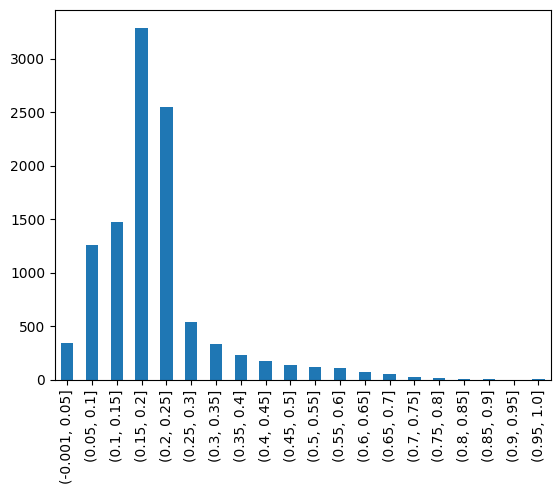

In [28]:
def stat_result(pp_ret):
    ret = pd.DataFrame({'label' : pp_ret})
    df_ret = ret.groupby(pd.cut(pp_ret, bins=20))['label'].agg('count')
    df_ret.plot(kind='bar')
    
stat_result(gbdt_pred)

print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

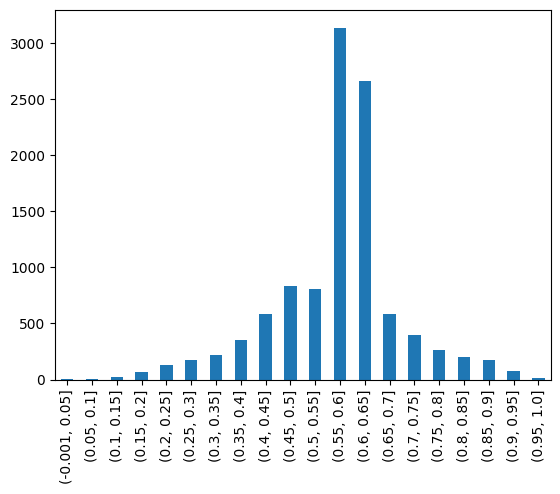

In [29]:
stat_result(xgb_pred4)

# 特征重要性分析

In [32]:
# gbdt 重要性分析
df_fea_importance = pd.DataFrame({'feat': gbdt_clf.feature_names_in_ , 'feat_importances' : gbdt_clf.feature_importances_ })
pd.set_option('display.max_rows', 100)
df_fea_importance.sort_values(by='feat_importances',ascending=False)

,feat,feat_importances
22,level_ord,0.066626
10,record_time,0.066335
5,term,0.062711
7,issue_time,0.056328
6,interest_rate,0.051204
14,balance_limit,0.046031
15,balance,0.042528
19,interest_rate_log,0.042354
2,zip_code,0.041876
11,history_time,0.041290


<AxesSubplot:xlabel='feat_importances', ylabel='feat'>

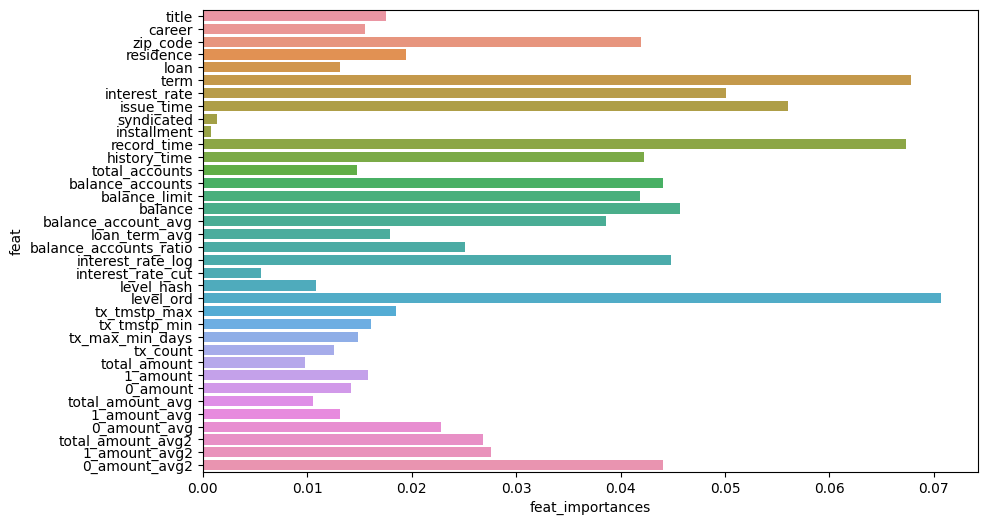

In [33]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10, 6))
sns.barplot(x='feat_importances', y='feat', data=df_fea_importance)
# df_fea_importance.plot(kind='bar')
# plt.set_title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()

# 预测v2

In [75]:
#无dummy
drop_fea = ['level', 'id']

train_data = pd.read_csv(train_dat_path, engine = 'python');
train_data = train_data.fillna(0)

test_data = pd.read_csv(test_dat_path, engine = 'python');
test_data = test_data.fillna(0)

train_test_data = pd.concat([train_data, test_data], axis=0, ignore_index = True)
train_test_data.drop(drop_fea, axis = 1, inplace=True)
train_test_data = train_test_data.fillna(0)
train_test_data.replace([np.inf, -np.inf], 0, inplace=True)
print(train_test_data)

train_train = train_test_data.iloc[:train_data.shape[0],:]
test_test = train_test_data.iloc[train_data.shape[0]:,:]

y_train = train_train['label'].values
X_train = train_train.drop(['label'],axis=1)
X_test = test_test.drop(['label'],axis=1)

print(X_train.shape)
print(X_test.shape)

       title  career  zip_code  residence   loan  term  interest_rate  \
0          9     0.0    221373          1   7200    36          10.95   
1          8    10.0    311681          0  21300    36          12.95   
2          8     7.0    271562          1  10400    60          21.05   
3          7     2.0    522083          0  33050    36          16.40   
4          8     3.0    101026          1   5200    36          14.35   
...      ...     ...       ...        ...    ...   ...            ...   
73529      0     8.0    601107          1  10000    12          18.85   
73530      0    10.0    601102          1  10000    12          29.30   
73531      0     4.0    601408          1  11000    12          24.75   
73532      0     3.0    601904          1   8000    12          22.00   
73533      2     1.0    601809          1   7000    12          14.95   

       issue_time  syndicated  installment  ...  tx_count  total_amount  \
0      1238631967           0            1  ... 

In [76]:
# gbdt model
gbdt_clf_pp, gbdt_pred_pp = gbdt_model(X_train, y_train, X_test, None)
print(len(gbdt_pre_ret_pp))

# xgb_clf3_pp, xgb_pred3_pp = xgb_feature3(X_train, y_train, X_test, None)
# print(len(xgb_pred3_pp))

xgb_clf4_pp, xgb_pred4_pp = xgb_feature4(X_train, y_train, X_test, None)
print(len(xgb_pred4_pp))

20054
[21:47:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


20054


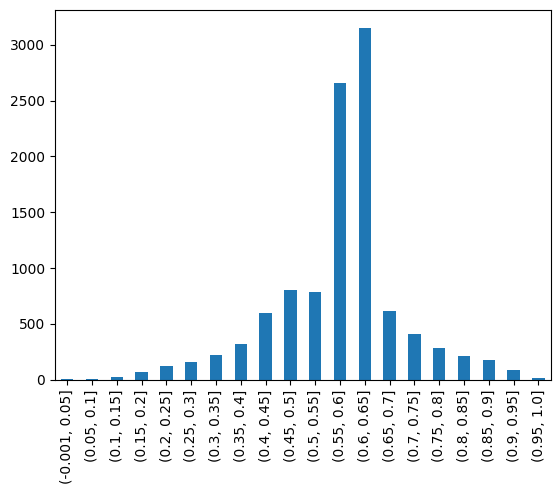

In [77]:
stat_result(gbdt_pre_ret_pp)

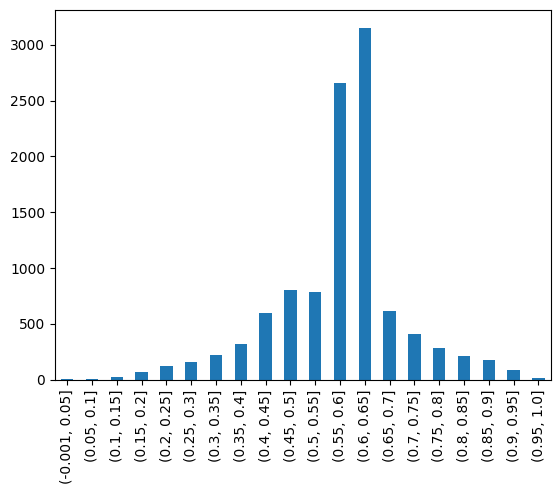

In [78]:
stat_result(xgb_pre_ret4_pp)

# 结果保存

In [38]:
def save_result(pre_ret):
    print('X_test', X_test)
    print(len(pre_ret))
    X_test = X_test.reset_index()
    X_test = X_test.rename(columns={'index':'id'})
    print('X_test', X_test)
    df_test_id = X_test[['id']].iloc[:,[0]]
    print('id \n ', df_test_id)
    print('df_test_id shape \n', df_test_id.shape)
    df_test_id['label0'] = pp_ret
    minmin = min(df_test_id['label0'])
    maxmax = max(df_test_id['label0'])
    df_test_id['label'] = df_test_id['label0'].map(lambda x:(x-minmin)/(maxmax-minmin))
    df_test_id[['id','label0']].to_csv('%s_gh_v0.csv' % suffix, encoding='utf-8', index=False, mode='w')
    df_test_id[['id','label']].to_csv('%s_gh_v1.csv' % suffix, encoding='utf-8', index=False, mode='w')
    !ls

save_result()

       title  career  zip_code  residence   loan  term  interest_rate  \
53480     10     5.0    512068          0   5950    36          14.10   
53481      8    10.0    401852          2  15350    36           5.25   
53482      8    10.0    321693          0  11050    36          13.65   
53483      8     7.0    231397          0  15350    36          14.20   
53484      7     7.0    171193          0   7800    36          10.00   
...      ...     ...       ...        ...    ...   ...            ...   
73529      0     8.0    601107          1  10000    12          18.85   
73530      0    10.0    601102          1  10000    12          29.30   
73531      0     4.0    601408          1  11000    12          24.75   
73532      0     3.0    601904          1   8000    12          22.00   
73533      2     1.0    601809          1   7000    12          14.95   

       issue_time  syndicated  installment  ...  tx_count  total_amount  \
53480  1054600001           0            0  ... 

,id
0,53480
1,53481
2,53482
3,53483
4,53484
...,...
20049,73529
20050,73530
20051,73531
20052,73532


label0
(-0.001, 0.05]       2
(0.05, 0.1]         14
(0.1, 0.15]         52
(0.15, 0.2]        113
(0.2, 0.25]        253
(0.25, 0.3]        347
(0.3, 0.35]        455
(0.35, 0.4]        657
(0.4, 0.45]       1234
(0.45, 0.5]       1365
(0.5, 0.55]       1421
(0.55, 0.6]       5765
(0.6, 0.65]       5222
(0.65, 0.7]       1117
(0.7, 0.75]        761
(0.75, 0.8]        462
(0.8, 0.85]        396
(0.85, 0.9]        289
(0.9, 0.95]        115
(0.95, 1.0]         14
Name: label0, dtype: int64


<AxesSubplot:xlabel='label0'>

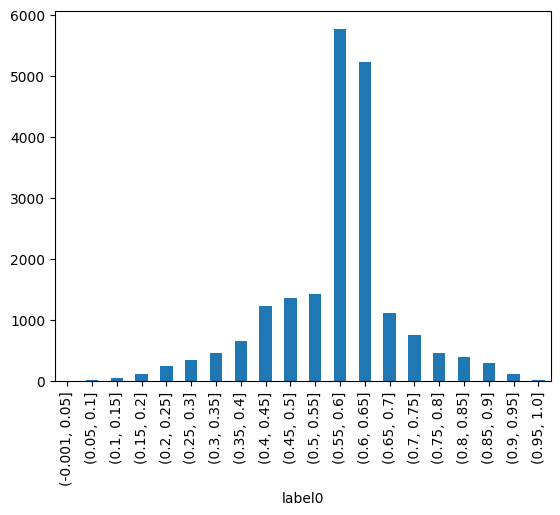

In [53]:
def stat_file_result(file_input):
    ret = pd.read_csv(file_input)
    df_ret = ret.groupby(pd.cut(ret['label0'],bins=20))['label0'].agg('count')
    print(df_ret)
    df_ret.plot(kind='bar')
stat_file_result('v7_gh_v1.csv')

label
(-0.001, 0.05]       2
(0.05, 0.1]         14
(0.1, 0.15]         52
(0.15, 0.2]        113
(0.2, 0.25]        253
(0.25, 0.3]        347
(0.3, 0.35]        455
(0.35, 0.4]        657
(0.4, 0.45]       1234
(0.45, 0.5]       1365
(0.5, 0.55]       1421
(0.55, 0.6]       5765
(0.6, 0.65]       5222
(0.65, 0.7]       1117
(0.7, 0.75]        761
(0.75, 0.8]        462
(0.8, 0.85]        396
(0.85, 0.9]        289
(0.9, 0.95]        115
(0.95, 1.0]         14
Name: label, dtype: int64


<AxesSubplot:xlabel='label'>

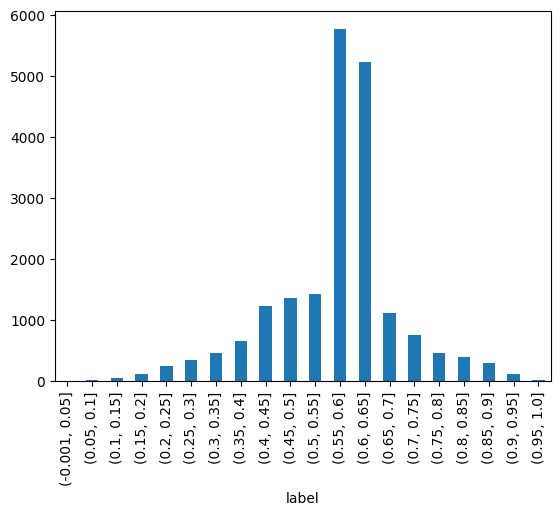

In [50]:
ret = pd.read_csv('v7_gh_v1.csv')
df_ret = ret.groupby(pd.cut(ret['label'],bins=20))['label'].agg('count')
print(df_ret)
df_ret.plot(kind='bar')

## 验证v2  :  LGB  

In [18]:
from sklearn.model_selection import train_test_split

dummy_fea_str = "level"
dummy_fea = dummy_fea_str.split(',')
drop_fea = ['tx_time_max', 'tx_time_min']
category_feature_str = "id,title,career,zip_code,residence,syndicated,installment,level,interest_rate_cut"
category_feature = category_feature_str.split(',')

sample_data_0 = pd.read_csv(train_dat_path, engine = 'python');
sample_data.drop(drop_fea, axis = 1, inplace=True)
sample_data = sample_data_0.fillna(0)
sample_data_concat.replace([np.inf, -np.inf], 0, inplace=True)

#1. lgb feature
#处理dummy变量
for _fea in dummy_fea:
    le = LabelEncoder()
    le.fit(sample_data[_fea].tolist())
    tmp = le.transform(sample_data[_fea].tolist())
    sample_data[_fea] = tmp
print('lgb sample data\n', sample_data)
sample_data_target = sample_data['label'].values
sample_data_x      = sample_data.drop(['label', 'id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(sample_data_x, sample_data_target, test_size=0.2, random_state=None, shuffle=True)

predict_result = lgb_feature(X_train, y_train, X_test, dummy_fea, None)
print('lgb_model valid auc : ', roc_auc_score(y_test, predict_result))

lgb sample data
           id  title  career  zip_code  residence   loan  term  interest_rate  \
0          0      9       0       271          1   7200    36          10.95   
1          1      8      10       508          0  21300    36          12.95   
2          2      8       7       424          1  10400    60          21.05   
3          3      7       2       766          0  33050    36          16.40   
4          4      8       3        25          1   5200    36          14.35   
...      ...    ...     ...       ...        ...    ...   ...            ...   
53475  53475      2       2      1057          1   9000    12          23.55   
53476  53476      0      10       916          1   8000    12          30.70   
53477  53477      2      10      1043          1  10000    12           9.40   
53478  53478      0      10       960          2   9000    12          24.40   
53479  53479      0      10       976          1  10000    12          17.60   

       issue_time  syn

# 验证v3 : stacking

In [44]:
from sklearn.model_selection import train_test_split

dummy_fea_str = "id,title,career,zip_code,residence,syndicated,installment,level"
dummy_fea = dummy_fea_str.split(',')

sample_data_0 = pd.read_csv(train_dat_path, engine = 'python');
sample_data = sample_data_0.fillna(0)

#1. lgb feature
#处理dummy变量
for _fea in dummy_fea:
    le = LabelEncoder()
    le.fit(sample_data[_fea].tolist())
    tmp = le.transform(sample_data[_fea].tolist())
    sample_data[_fea] = tmp
print('lgb sample data\n', sample_data)
sample_data_target = sample_data['label'].values
sample_data_x      = sample_data.drop(['label'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(sample_data_x, sample_data_target, test_size=0.2, random_state=None, shuffle=True)
lgb_dataset = Dataset(X_train=X_train, y_train=y_train, X_test = X_test, y_test= None, use_cache=False)


##2. xgb feature
sample_data = sample_data_0.fillna(0)
dummy_df = pd.get_dummies(sample_data.loc[:,dummy_fea])
print('xgb dummy_df\n ',dummy_df)
sample_data_concat = pd.concat([sample_data, dummy_df], axis=1)
sample_data_concat = sample_data_concat.fillna(0)
vaild_sample_data = sample_data_concat.drop(dummy_fea, axis=1)
print('xgb valid sample data', vaild_sample_data.columns)

sample_data_target = vaild_sample_data['label'].values
sample_data_x = vaild_sample_data.drop(['label'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(sample_data_x, sample_data_target, test_size=0.2, random_state=None, shuffle=True)
xgb_dataset = Dataset(X_train=X_train, y_train=y_train, X_test = X_test, y_test= None, use_cache=False)

model_xgb  = Regressor(dataset=xgb_dataset, estimator=xgb_feature,name='xgb',use_cache=False)
model_xgb2 = Regressor(dataset=xgb_dataset, estimator=xgb_feature2,name='xgb2',use_cache=False)
model_xgb3 = Regressor(dataset=xgb_dataset, estimator=xgb_feature3,name='xgb3',use_cache=False)
# model_lgb = Regressor(dataset=lgb_dataset, estimator=lgb_feature,name='lgb',use_cache=False)
model_gbdt = Regressor(dataset=xgb_dataset, estimator=gbdt_model,name='gbdt',use_cache=False)



lgb sample data
           id  title  career  zip_code  residence   loan  term  interest_rate  \
0          0      9       0       271          1   7200    36          10.95   
1          1      8      10       508          0  21300    36          12.95   
2          2      8       7       424          1  10400    60          21.05   
3          3      7       2       766          0  33050    36          16.40   
4          4      8       3        25          1   5200    36          14.35   
...      ...    ...     ...       ...        ...    ...   ...            ...   
53475  53475      2       2      1057          1   9000    12          23.55   
53476  53476      0      10       916          1   8000    12          30.70   
53477  53477      2      10      1043          1  10000    12           9.40   
53478  53478      0      10       960          2   9000    12          24.40   
53479  53479      0      10       976          1  10000    12          17.60   

       issue_time  syn

# 模型训练

In [45]:

pipeline = ModelsPipeline(model_xgb, model_xgb2, model_xgb3, model_gbdt)
stack_ds = pipeline.stack(k=5, seed=111, add_diff=False, full_test=True)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression, parameters={'fit_intercept': False})
predict_result = stacker.predict()

print('ModelsPipeline(model_xgb, model_xgb2, model_xgb3, model_gbdt) valid auc', roc_auc_score(y_test, predict_result))


[11:58:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:58:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:58:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

## lgb feature

In [ ]:
train_data = pd.read_csv('train.dat',engine = 'python');
train_data = train_data.fillna(0)

test_data = pd.read_csv('test.dat',engine = 'python');
test_data = test_data.fillna(0)

train_test_data = pd.concat([train_data, test_data],axis=0,ignore_index = True)
train_test_data = train_test_data.fillna(0)

train_data = train_test_data.iloc[:train_data.shape[0],:]
test_data = train_test_data.iloc[train_data.shape[0]:,:]

#处理dummy变量
for _fea in dummy_fea:
    print(_fea)
    le = LabelEncoder()
    le.fit(train_data[_fea].tolist() + test_data[_fea].tolist())
    tmp = le.transform(train_data[_fea].tolist() + test_data[_fea].tolist())
    train_data[_fea] = tmp[:train_data.shape[0]]
    test_data[_fea]  = tmp[train_data.shape[0]:]
    
train_x = train_data.drop(['label'],axis=1)
test_x = test_data.drop(['label'],axis=1)
lgb_dataset = Dataset(train_x, train_data['label'], test_x, use_cache=False)

## xgb feature

In [ ]:
train_data = pd.read_csv('train.dat',engine = 'python');
train_data = train_data.fillna(0)

test_data = pd.read_csv('test.dat',engine = 'python');
test_data = test_data.fillna(0)

train_test_data = pd.concat([train_data, test_data], axis=0, ignore_index = True)
train_test_data = train_test_data.fillna(0)

dummy_df = pd.get_dummies(train_test_data.loc[:,dummy_fea])
train_test_data = pd.concat([train_test_data, dummy_df],axis=1)
train_test_data = train_test_data.drop(dummy_fea, axis=1)

train_train = train_test_data.iloc[:train_data.shape[0],:]
test_test = train_test_data.iloc[train_data.shape[0]:,:]

train_train_x = train_train.drop(['label'],axis=1)
test_test_x = test_test.drop(['label'],axis=1)

xgb_dataset = Dataset(X_train=train_train_x, y_train=train_train['label'], X_test = test_test_x, y_test= None, use_cache=False)

## stacking

In [ ]:
model_xgb = Regressor(dataset=xgb_dataset, estimator=xgb_feature,name='xgb',use_cache=False)
model_xgb2 = Regressor(dataset=xgb_dataset, estimator=xgb_feature2,name='xgb2',use_cache=False)
model_xgb3 = Regressor(dataset=xgb_dataset, estimator=xgb_feature3,name='xgb3',use_cache=False)
model_lgb = Regressor(dataset=lgb_dataset, estimator=lgb_feature,name='lgb',use_cache=False)
model_gbdt = Regressor(dataset=xgb_dataset, estimator=gbdt_model,name='gbdt',use_cache=False)
pipeline = ModelsPipeline(model_xgb, model_xgb2, model_xgb3, model_gbdt)
stack_ds = pipeline.stack(k=5, seed=111, add_diff=False, full_test=True)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression,parameters={'fit_intercept': False})
predict_result = stacker.predict()

In [ ]:
ans = pd.read_csv('testaa.csv')
ans['PROB'] = predict_result
minmin = min(ans['PROB']),
maxmax = max(ans['PROB'])
ans['PROB'] = ans['PROB'].map(lambda x:(x-minmin)/(maxmax-minmin))
ans['PROB'] = ans['PROB'].map(lambda x:'%.4f' % x)
ans.to_csv('./ans_stacking.csv',index=None)